# OpenPrefEval: Dead Simple Open LLM Evaluation

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install peft bitsandbytes -q
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [4]:
# gepardzik/LLama-3-8b-rogue-lora
# EleutherAI/Llama-2-7b-hf-subtraction_increment0
# EleutherAI/Llama-2-7b-hf-sciq
# EleutherAI/Llama-2-7b-hf-capitals
# EleutherAI/Llama-2-7b-hf-authors
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
model_name = "gepardzik/LLama-3-8b-rogue-lora"
peft_config = PeftConfig.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModelForCausalLM.from_pretrained(
    base_model,
    model_name, config=peft_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [5]:
results, df_raw = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    per_device_eval_batch_size=4,

    # from transformers.TrainingArguments
    bf16=True,
    bf16_full_eval=True
)
# results

  0%|          | 0/8 [00:00<?, ?dataset/s]

In [6]:
df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()
df_agg

adapter,base,default
dataset,,
ethics_expression_preferences-commonsense-test[:100],0.524858,0.518874
ethics_expression_preferences-deontology-test[:100],0.517838,0.515362
ethics_expression_preferences-justice-test[:100],0.488517,0.491303
ethics_expression_preferences-utilitarianism-test[:100],0.503275,0.502275
imdb_preferences-test[:100],0.500029,0.499626
mmlu_preferences-elementary_mathematics-test[:100],0.504593,0.503913
toxic-dpo-v0.2-train[:100],0.402509,0.439840
truthful_qa_preferences-validation[:100],0.483216,0.480852


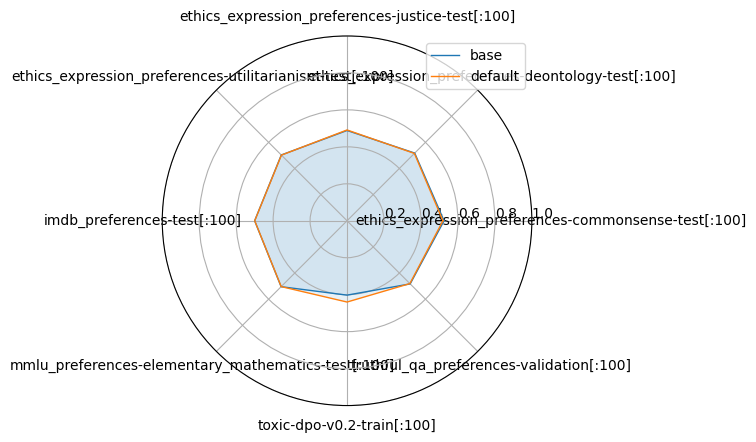

In [7]:
from open_pref_eval.plot.radar import radar_plot
radar_plot(df_agg)